# Step 1: Data Preparation

This is for the final dataset containing all texts, in both English and any other foreign language. All texts have been truncated at the mean value threshold of 12558 characters.

In [19]:
## CODE ADAPTED FROM: https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

In [20]:
import numpy as np
import pandas as pd

In [21]:
truncated = pd.read_csv("FINAL_DATASET_TRUNC.csv", index_col=0)
truncated.head()

,Text,organization,original_language,Text_translated
0,2 Degrees Investing Initiative - World Benchma...,2° investing initiative (2°ii),english,2 Degrees Investing Initiative - World Benchma...
1,2 Degrees Investing Initiative in standoff wit...,2° investing initiative (2°ii),english,2 Degrees Investing Initiative in standoff wit...
2,2° Investing Initiative GRESB About Our Work O...,2° investing initiative (2°ii),english,2° Investing Initiative GRESB About Our Work O...
3,Magic Garden Seeds - Samen & Saatgut Coupon Re...,A SEED Europe,english,Magic Garden Seeds - Samen & Saatgut Coupon Re...
4,A SEED Europe | European Youth Portal Den euro...,A SEED Europe,english,A SEED Europe | European Youth Portal Den euro...


In [22]:
# FOR EACH ORGANIZATION, MERGE THE TEXTS CORRESPONDING TO THAT ORGANIZATION

In [23]:
unique_orgs = list(truncated.organization.unique())
unique_orgs

['2° investing initiative (2°ii)',
 'A SEED Europe',
 'A Sud Ecology and Cooperation - Onlus',
 'ACT Alliance - Action by Churches Together',
 'Abibimman Foundation',
 'Academy for Mountain Environics',
 'Action Planéterre',
 'Action Solidarité Tiers-Monde a.s.b.l.',
 'ActionAid International',
 'Adaptation Fund Board',
 'Adelphi Research',
 'Advocates for the Environment, Inc.',
 'Africa Centre for Citizens Orientation',
 'Africa Youths International Development Foundation',
 'African Centre for Technology Studies',
 'African Centre of Meteorological Application for Development',
 'African Climate Change Research Centre',
 'African Development Bank Group',
 'African Forest Forum',
 'African Union Commission',
 'African Wildlife Foundation',
 'African, Caribbean and Pacific Group of States',
 'Agriconsulting S.p.A.',
 'Air and Waste Management Association',
 'All China Environment Federation',
 'All India Women’s Conference',
 'Alliance to Save Energy',
 'Amazon Environmental Research 

In [24]:
text_collection = []

for org in unique_orgs:
    merged_text = ' '.join(str(x) for x in truncated.Text_translated[truncated.organization == org])
    text_collection.append(merged_text)
    

In [25]:
print(len(unique_orgs), len(text_collection))

1118 1118


In [26]:
df = pd.DataFrame(list(zip(list(unique_orgs), text_collection)), columns=['organization', 'Text'])

In [27]:
df

,organization,Text
0,2° investing initiative (2°ii),2 Degrees Investing Initiative - World Benchma...
1,A SEED Europe,Magic Garden Seeds - Samen & Saatgut Coupon Re...
2,A Sud Ecology and Cooperation - Onlus,Who we are - Progetto Sud | Istituto per la Co...
3,ACT Alliance - Action by Churches Together,About us | ACT Alliance EU About us – ACT Alli...
4,Abibimman Foundation,Abibiman Foundation Home Who we are Board of D...
...,...,...
1113,ZOI Environment Network,Products | Zoï Environment Network Home About...
1114,Zhenjiang Green Sanshan Environmental Public W...,Department of Human Services [if IE 9] You may...
1115,atmosfair gGmbH,Emissions calculation - atmosfair Contact FAQs...
1116,iuventum e.V.,"iuventum - Wikipedia iuventum From Wikipedia, ..."


### Americanizing all the words (i.e. transforming all words that are originally in British English to American English)

In [31]:
import requests

def americanize(string):
    url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
    british_to_american_dict = dict(requests.get(url).json())    

    for british_spelling, american_spelling in british_to_american_dict.items():
        string = string.replace(british_spelling, american_spelling)
  
    return string

In [32]:
# Apply the americanize function to the dataframe
df['Text'] = df['Text'].apply(func = americanize)

In [34]:
import re
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

In [35]:
# REMOVE STOP WORDS
# NLTK Stop words
from nltk.corpus import stopwords
stop_words_eng = list(stopwords.words('english'))
stop_words_fr = list(stopwords.words('french'))
stop_words_sp = list(stopwords.words('spanish'))
stop_words_de = list(stopwords.words('german'))
stop_words = stop_words_eng + stop_words_fr + stop_words_sp + stop_words_de
stop_words.extend(["retrieved", "retrieve", "january","february","march","april", "may","june", "july", 
                   "august","september", "october", "november", "december","wikipedia", "facebook", 
                   "instagram", "linkedIn","used", "u", "U", "b", "lat", "lon", 
                   "archived", "archive", "download","about", "events", "careers", "contact"])

In [36]:
# Convert to list 
data = df.Text.values.tolist()  
# Remove new line characters 
data = [re.sub(r'\s+', ' ', sent) for sent in data]  
# Remove distracting single quotes 
data = [re.sub(r"\'", "", sent) for sent in data]  
pprint(data[:1])

['2 Degrees Investing Initiative - World Benchmarking Alliance Skip to content '
 'Building a movement How it started Mission and vision Alliance About the '
 'Alliance Join the Alliance Meet our Allies How we work Seven systems '
 'transformations Theory of change Benchmarking SDG2000 Benchmarks Social '
 'Gender Benchmark Corporate Human Rights Benchmark Food and Agriculture '
 'Seafood Stewardship Index Access to Seeds Index Climate and Energy Just '
 'transition Nature Digital Inclusion Financial System Companies About us Team '
 'Careers and culture Funding partners Governance Ambassadors Finances Contact '
 'Content News and events Keeping you updated on our work Research and '
 'publications Sharing our latest data, findings and insights Impact Building '
 'a movement In the media Allies Companies This site makes use of third-party '
 'cookies for analytics. By continuing to use the site, you accept the use of '
 'cookies. Our privacy statement Accept France 2 Degrees Investing 

In [37]:
# TRANSFORM TEXT TO LIST OF INDIVIDUAL WORDS

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['degrees', 'investing', 'initiative', 'world', 'benchmarking', 'alliance', 'skip', 'to', 'content', 'building', 'movement', 'how', 'it', 'started', 'mission', 'and', 'vision', 'alliance', 'about', 'the', 'alliance', 'join', 'the', 'alliance', 'meet', 'our', 'allies', 'how', 'we', 'work', 'seven', 'systems', 'transformations', 'theory', 'of', 'change', 'benchmarking', 'sdg', 'benchmarks', 'social', 'gender', 'benchmark', 'corporate', 'human', 'rights', 'benchmark', 'food', 'and', 'agriculture', 'seafood', 'stewardship', 'index', 'access', 'to', 'seeds', 'index', 'climate', 'and', 'energy', 'just', 'transition', 'nature', 'digital', 'inclusion', 'financial', 'system', 'companies', 'about', 'us', 'team', 'careers', 'and', 'culture', 'funding', 'partners', 'governance', 'ambassadors', 'finances', 'contact', 'content', 'news', 'and', 'events', 'keeping', 'you', 'updated', 'on', 'our', 'work', 'research', 'and', 'publications', 'sharing', 'our', 'latest', 'data', 'findings', 'and', 'insigh

## Extra Step from Previous Discussions:
### Removing words with less than 2 characters

In [38]:
def remove_two_letter_words(words):
    result = []
    for word in words:
        if len(word) > 2:
            result.append(word)
    return result

for i in range(len(data_words)):
    data_words[i] = remove_two_letter_words(data_words[i])
    

In [39]:
# sanity check:
local_min = []
for i in range(len(data_words)):
    word_list = data_words[i]
    local_min.append(min([len(word) for word in word_list]))
print(min(local_min))

3


In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['degrees', 'investing', 'initiative', 'world', 'benchmarking', 'alliance', 'skip_content', 'building', 'movement', 'how', 'started', 'mission', 'and', 'vision', 'alliance', 'about', 'the', 'alliance', 'join', 'the', 'alliance', 'meet', 'our', 'allies', 'how', 'work', 'seven', 'systems', 'transformations', 'theory', 'change', 'benchmarking', 'sdg', 'benchmarks', 'social', 'gender', 'benchmark', 'corporate', 'human_rights', 'benchmark', 'food', 'and', 'agriculture', 'seafood', 'stewardship', 'index', 'access', 'seeds', 'index', 'climate', 'and', 'energy', 'just_transition', 'nature', 'digital', 'inclusion', 'financial', 'system', 'companies', 'about', 'team', 'careers', 'and', 'culture', 'funding', 'partners', 'governance', 'ambassadors', 'finances', 'contact', 'content', 'news', 'and', 'events', 'keeping', 'you', 'updated', 'our', 'work', 'research', 'and', 'publications', 'sharing', 'our', 'latest', 'data', 'findings', 'and', 'insights', 'impact', 'building', 'movement', 'the', 'media

In [49]:
# ?gensim.models.Phrases

In [50]:
# ?gensim.models.phrases.original_scorer

In [41]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # SpaCy documentation: https://spacy.io/usage/spacy-101

def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [42]:
# CALL THE FUNCTIONS IN ORDER:

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['degree', 'invest', 'initiative', 'world', 'benchmarking', 'alliance', 'skip_content', 'building', 'movement', 'start', 'mission', 'vision', 'alliance', 'alliance', 'join', 'alliance', 'meet', 'ally', 'work', 'seven', 'system', 'transformation', 'theory', 'change', 'benchmarke', 'sdg', 'benchmark', 'social', 'gender', 'benchmark', 'corporate', 'human_rights', 'benchmark', 'food', 'agriculture', 'seafood', 'stewardship', 'index', 'access', 'seed', 'index', 'climate', 'energy', 'transition', 'nature', 'digital', 'inclusion', 'financial', 'system', 'company', 'team', 'culture', 'funding', 'partner', 'governance', 'ambassador', 'finance', 'content', 'news', 'keep', 'update', 'work', 'research', 'publication', 'share', 'late', 'datum', 'finding', 'insight', 'impact', 'building', 'movement', 'medium', 'ally', 'company', 'site', 'make', 'use', 'third_party', 'cookie', 'analytic', 'continue', 'use', 'site', 'accept', 'use', 'cookie', 'privacy', 'statement', 'accept', 'france', 'degree', 'inv

In [43]:
# started 20:21 -> ended 20:25

In [44]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  # doc2bow = document to bag-of-words
# View 
print(corpus[:1])

[[(0, 2), (1, 3), (2, 3), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 2), (9, 1), (10, 6), (11, 3), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 14), (20, 3), (21, 7), (22, 7), (23, 2), (24, 2), (25, 8), (26, 2), (27, 4), (28, 4), (29, 7), (30, 2), (31, 1), (32, 3), (33, 1), (34, 2), (35, 2), (36, 4), (37, 2), (38, 2), (39, 2), (40, 1), (41, 1), (42, 1), (43, 2), (44, 4), (45, 2), (46, 2), (47, 1), (48, 4), (49, 1), (50, 1), (51, 2), (52, 8), (53, 2), (54, 2), (55, 9), (56, 2), (57, 1), (58, 2), (59, 3), (60, 1), (61, 5), (62, 14), (63, 1), (64, 2), (65, 2), (66, 9), (67, 2), (68, 2), (69, 2), (70, 2), (71, 1), (72, 3), (73, 2), (74, 1), (75, 7), (76, 1), (77, 2), (78, 1), (79, 1), (80, 4), (81, 1), (82, 2), (83, 1), (84, 1), (85, 4), (86, 2), (87, 1), (88, 5), (89, 2), (90, 1), (91, 7), (92, 1), (93, 10), (94, 5), (95, 1), (96, 2), (97, 1), (98, 5), (99, 2), (100, 2), (101, 4), (102, 1), (103, 1), (104, 5), (105, 4), (106, 2), (107, 3), (108, 1), (109, 2), (110,

In [45]:
# Gensim creates unique id for each word in the document. 
# The mapping of the corpus is as follows: every pair (a, b) in fact represents (word_id, word_frequency). 

# If you want to see what word corresponds to a given id, 
# then pass the id as a key to dictionary. 
# Example: 
id2word[4]

'adaptation'

In [46]:
# to see the word frequency distribution in a given document, run this:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accept', 2),
  ('access', 3),
  ('action', 3),
  ('active', 2),
  ('adaptation', 2),
  ('advance', 1),
  ('africa', 1),
  ('agriculture', 2),
  ('align', 2),
  ('alignment', 1),
  ('alliance', 6),
  ('ally', 3),
  ('already', 1),
  ('ambassador', 2),
  ('america', 1),
  ('american', 2),
  ('analysis', 1),
  ('analytic', 1),
  ('analytical', 1),
  ('article', 14),
  ('asia', 3),
  ('assessment', 7),
  ('asset', 7),
  ('asset_manager', 2),
  ('asset_owner', 2),
  ('aug', 8),
  ('award', 2),
  ('bank', 4),
  ('become', 4),
  ('benchmark', 7),
  ('benchmarke', 2),
  ('benchmarking', 1),
  ('berlin', 3),
  ('best_practice', 1),
  ('big', 2),
  ('biodiversity', 2),
  ('blue', 4),
  ('board', 2),
  ('bond', 2),
  ('brainwave', 2),
  ('brand', 1),
  ('browse', 1),
  ('brussels', 1),
  ('building', 2),
  ('bullsh', 4),
  ('business', 2),
  ('cal', 2),
  ('calendar', 1),
  ('canada', 4),
  ('cancel', 1),
  ('carbon', 1),
  ('carbon_price', 2),
  ('category', 8),
  ('central', 2),
  ('ceo', 2

In [47]:

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                           id2word=id2word,
#                                           num_topics=20, 
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha='auto',
#                                           per_word_topics=True)


coherence = []
for k in range(1,51):
    print('Round: '+ str(k))
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # document corpus
                                           id2word=id2word, # dictionary
                                           num_topics=k, # number of topics
                                           random_state=0, # random seem for model reproducibility
                                           update_every=1, # updates the coefficients at every x passes of the dataset; set to 1
                                           chunksize=100, # how many texts to process at once
                                           passes=10, # number of passes through the dataset for coefficient estimation
                                           alpha='auto', # Dirichlet distribution parameter that is automatically inferred in this case
                                           per_word_topics=True) #assign each word to at least a topic; 
                                                                #if set to False, words that are not indicative are going to be omitted
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, 
                                                     corpus = corpus,
                                                     coherence='u_mass')   
                                                
    coherence.append((k,cm.get_coherence()))

Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Round: 30
Round: 31
Round: 32
Round: 33
Round: 34
Round: 35
Round: 36
Round: 37
Round: 38
Round: 39
Round: 40
Round: 41
Round: 42
Round: 43
Round: 44
Round: 45
Round: 46
Round: 47
Round: 48
Round: 49
Round: 50


In [36]:
# ?gensim.models.coherencemodel.CoherenceModel

# started: 20:26 -> 21:41

In [ ]:
?gensim.models.ldamodel.LdaModel

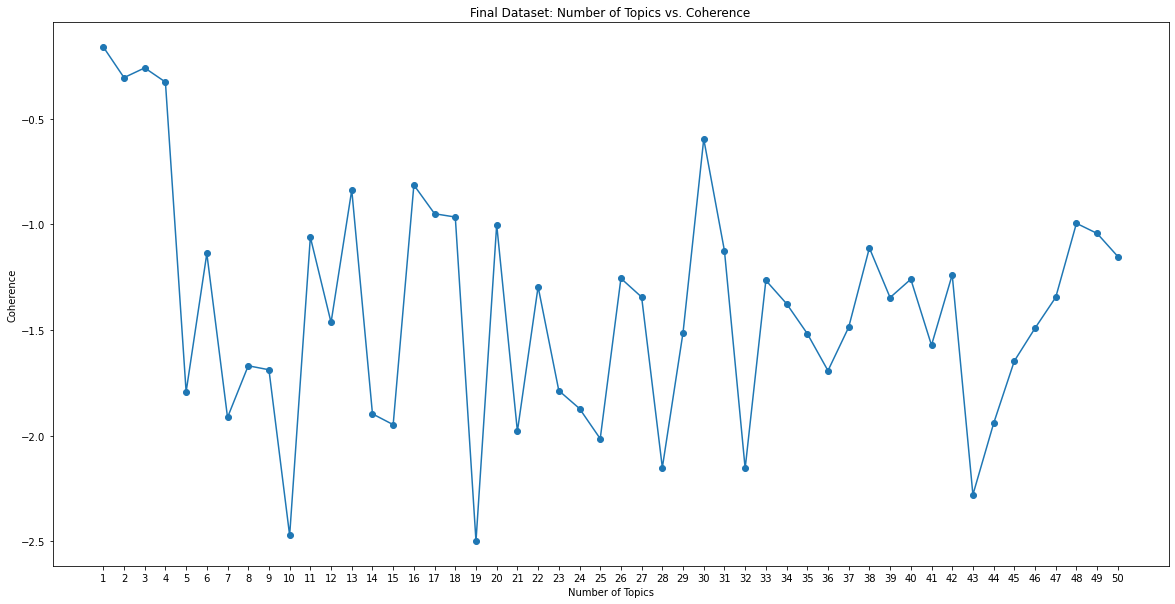

In [49]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.figure(figsize=(20,10))
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Final Dataset: Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
#plt.show()
plt.savefig("FINAL Dataset Coherence Crossval.png", facecolor = "white")

In [50]:
# either 4 or 30 (or 16)

# Start with 4:
lda_model_4t = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_4t.show_topics(4, num_words=20, formatted=False)




[(0,
  [('university', 0.012349071),
   ('college', 0.0092805885),
   ('student', 0.008151387),
   ('school', 0.0074363914),
   ('yale', 0.006557824),
   ('campus', 0.0058246832),
   ('new', 0.0058015226),
   ('first', 0.0042420267),
   ('state', 0.0042062704),
   ('program', 0.0039839586),
   ('community', 0.0037892826),
   ('year', 0.003690913),
   ('one', 0.0035883174),
   ('health', 0.0034314257),
   ('city', 0.0034165771),
   ('education', 0.0029618999),
   ('life', 0.0027958907),
   ('church', 0.0026793582),
   ('history', 0.0026504311),
   ('see', 0.002636196)]),
 (1,
  [('climate', 0.010470677),
   ('organization', 0.008296196),
   ('development', 0.007098546),
   ('world', 0.006890603),
   ('project', 0.0061754384),
   ('work', 0.0061232317),
   ('international', 0.006023678),
   ('policy', 0.0056463317),
   ('change', 0.005404889),
   ('global', 0.00505462),
   ('sustainable', 0.0048159533),
   ('member', 0.0047818874),
   ('news', 0.0044246283),
   ('environmental', 0.004131

In [53]:
lda_model_4t.save("final_data_4topics_model")

In [54]:
pyLDAvis.enable_notebook()
vis_4t = pyLDAvis.gensim_models.prepare(lda_model_4t, corpus, id2word, mds='mmds', sort_topics = False)
vis_4t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.173610  0.079159       1        1  15.302218
1      0.043515 -0.156900       2        1  50.641497
2     -0.116944 -0.109233       3        1  22.494320
3     -0.100180  0.186974       4        1  11.561965, topic_info=              Term          Freq         Total Category  logprob  loglift
1007    university  19509.000000  19509.000000  Default  30.0000  30.0000
294       research  14872.000000  14872.000000  Default  29.0000  29.0000
110         energy  15009.000000  15009.000000  Default  28.0000  28.0000
962        student  11360.000000  11360.000000  Default  27.0000  27.0000
1968       college   5143.000000   5143.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
226           name   1015.694184   4218.501545   Topic4  -5.9076   0.7335
316            see   1103.600413   6136.609936   Topic4  -5.8246   0.4418
1587     president    933.307674   3507.255474   Topic4  -5.9922   0.8336
956          state   1057.537401   6236.509682   Topic4  -5.8673   0.3830
816   organization   1107.351612  15846.359606   Topic4  -5.8212  -0.5035

[372 rows x 6 columns], token_table=        Topic      Freq             Term
term                                    
1042        1  0.342251         academic
1042        2  0.068074         academic
1042        3  0.584431         academic
1042        4  0.005333         academic
10769       1  0.004597  acceptance_rate
...       ...       ...              ...
13673       3  0.797622             york
13673       4  0.000846             york
121658      2  0.999626             ypsa
121684      2  0.998427              zoi
121685      2  0.998377       zoinet_org

[711 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [55]:
pyLDAvis.save_html(vis_4t, 'FINAL_4topics_pyLDAvis.html')

In [56]:
lda_model_30t = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_30t.show_topics(30, num_words=20, formatted=False)

[(0,
  [('icc_icl', 8.200554e-06),
   ('heid', 8.200554e-06),
   ('gleisslutz', 8.200554e-06),
   ('guillaumin', 8.200554e-06),
   ('ibahri', 8.200554e-06),
   ('lawcontract', 8.200554e-06),
   ('ilaindia', 8.200554e-06),
   ('internal_displacement', 8.200554e-06),
   ('intlawyer', 8.200554e-06),
   ('jmm', 8.200554e-06),
   ('kavala', 8.200554e-06),
   ('khaleq', 8.200554e-06),
   ('kiara', 8.200554e-06),
   ('lagesse', 8.200554e-06),
   ('lawart', 8.200554e-06),
   ('lawbanke', 8.200554e-06),
   ('lawbankruptcy', 8.200554e-06),
   ('howardkennedy', 8.200554e-06),
   ('goodslabour', 8.200554e-06),
   ('hermosilla', 8.200554e-06)]),
 (1,
  [('company', 0.0125158755),
   ('industry', 0.0075966488),
   ('bank', 0.0066467593),
   ('coal', 0.006241386),
   ('new', 0.0061564636),
   ('steel', 0.006088422),
   ('business', 0.0060688895),
   ('datum', 0.0058486294),
   ('report', 0.005384414),
   ('use', 0.0052274372),
   ('world', 0.0051872875),
   ('org', 0.0046804147),
   ('office', 0.0044

In [58]:
pyLDAvis.enable_notebook()
vis_30t = pyLDAvis.gensim_models.prepare(lda_model_30t, corpus, id2word, mds='mmds', sort_topics = False)
vis_30t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.186255 -0.168693       1        1   0.000180
1      0.265894  0.222491       2        1   9.624535
2      0.139367  0.343769       3        1  14.755018
3     -0.186255 -0.168693       4        1   0.000181
4     -0.109300 -0.275864       5        1   0.196721
5      0.237540 -0.282188       6        1   0.887829
6     -0.186255 -0.168693       7        1   0.000179
7     -0.186255 -0.168693       8        1   0.000175
8      0.179608  0.277294       9        1  16.402449
9      0.029679  0.447411      10        1   5.629288
10    -0.186255 -0.168693      11        1   0.000176
11     0.221856  0.308928      12        1  11.499914
12    -0.186255 -0.168693      13        1   0.000177
13    -0.274333  0.070464      14        1   0.609318
14     0.409400  0.049299      15        1   5.822980
15    -0.186255 -0.168693      16        1   0.000178
16    -0.018283  0.372095      17        1   4.627463
17    -0.234244  0.265729      18        1   0.781173
18     0.397123  0.133717      19        1   4.902016
19    -0.220338 -0.151088      20        1   0.037373
20    -0.334597  0.213857      21        1   1.087101
21    -0.186255 -0.168693      22        1   0.000178
22     0.313884  0.309577      23        1  12.549549
23    -0.186255 -0.168693      24        1   0.000182
24     0.168555 -0.334945      25        1   0.826631
25     0.298296  0.098451      26        1   5.093663
26     0.384554 -0.063842      27        1   3.698250
27    -0.186812 -0.169420      28        1   0.001273
28    -0.186255 -0.168693      29        1   0.000176
29     0.194700 -0.148806      30        1   0.965673, topic_info=              Term          Freq         Total Category  logprob  loglift
1007    university  19504.000000  19504.000000  Default  30.0000  30.0000
110         energy  18513.000000  18513.000000  Default  29.0000  29.0000
45        business   7711.000000   7711.000000  Default  28.0000  28.0000
816   organization  17940.000000  17940.000000  Default  27.0000  27.0000
62         climate  22614.000000  22614.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
274         public    239.847163   6292.502979  Topic30  -4.8683   1.3730
166         impact    226.062305   4231.507819  Topic30  -4.9275   1.7106
266         policy    255.278671  13761.153714  Topic30  -4.8059   0.6529
428         annual    206.781591   2986.453304  Topic30  -5.0166   1.9699
989            top    204.344659   2724.024919  Topic30  -5.0285   2.0500

[2058 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
3294       6  0.991745  absolutely_essential
1042       3  0.012751              academic
1042       9  0.064997              academic
1042      15  0.006531              academic
1042      18  0.013062              academic
...      ...       ...                   ...
18961      9  0.053987                zurich
18961     26  0.943177                zurich
13920      9  0.994292               русскии
15400     12  0.305531                   日本語
15400     30  0.687445                   日本語

[4682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [61]:
pyLDAvis.save_html(vis_30t, 'FINAL_30topics_pyLDAvis.html')

In [50]:
# with open('untruncated_model_3topics.txt', "w") as outfile:
#    outfile.write("\n \n".join(str(item) for item in list(lda_model_3t.show_topics(3, num_words=25, formatted=False))))

In [62]:
lda_model_30t.save("final_data_30topics_model")

In [63]:
lda_model_16t = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model_16t.show_topics(16, num_words=25, formatted=False)


[(0,
  [('icc_icl', 8.200553e-06),
   ('hjmasialaw', 8.200553e-06),
   ('lawenvironment', 8.200553e-06),
   ('hasenbuelweg', 8.200553e-06),
   ('guillaumin', 8.200553e-06),
   ('goodslabour', 8.200553e-06),
   ('gleisslutz', 8.200553e-06),
   ('hermosilla', 8.200553e-06),
   ('heid', 8.200553e-06),
   ('ibahri', 8.200553e-06),
   ('lawcontract', 8.200553e-06),
   ('hjerrild', 8.200553e-06),
   ('ilaindia', 8.200553e-06),
   ('intlawyer', 8.200553e-06),
   ('jmm', 8.200553e-06),
   ('kavala', 8.200553e-06),
   ('khaleq', 8.200553e-06),
   ('kiara', 8.200553e-06),
   ('lagesse', 8.200553e-06),
   ('lawart', 8.200553e-06),
   ('lawbanke', 8.200553e-06),
   ('lawbankruptcy', 8.200553e-06),
   ('howardkennedy', 8.200553e-06),
   ('internal_displacement', 8.200553e-06),
   ('horten', 8.200553e-06)]),
 (1,
  [('cookie', 0.01655767),
   ('company', 0.0153702125),
   ('information', 0.010584377),
   ('website', 0.010481388),
   ('bank', 0.009214179),
   ('coal', 0.008875112),
   ('steel', 0.008

In [64]:
lda_model_16t.save("final_data_16topics_model")

In [65]:
pyLDAvis.enable_notebook()
vis_16t = pyLDAvis.gensim_models.prepare(lda_model_16t, corpus, id2word, mds='mmds', sort_topics = False)
vis_16t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.207339  0.175098       1        1   0.000173
1     -0.138674 -0.226306       2        1   5.804295
2     -0.292187 -0.221407       3        1  23.947272
3     -0.135991  0.251966       4        1   0.935971
4      0.207339  0.175098       5        1   0.000180
5      0.036934 -0.356981       6        1   8.329210
6      0.090342  0.340488       7        1   0.414807
7      0.240422  0.140231       8        1   0.089632
8     -0.260734 -0.147255       9        1  21.033978
9      0.268461 -0.230939      10        1   2.076011
10     0.207339  0.175098      11        1   0.000173
11    -0.335739 -0.104524      12        1  14.889041
12     0.207339  0.175098      13        1   0.000172
13    -0.390616  0.041658      14        1  10.871393
14    -0.118916 -0.362421      15        1  11.607520
15     0.207339  0.175098      16        1   0.000173, topic_info=            Term          Freq         Total Category  logprob  loglift
1007  university  19933.000000  19933.000000  Default  30.0000  30.0000
1792       water  10258.000000  10258.000000  Default  29.0000  29.0000
45      business   7589.000000   7589.000000  Default  28.0000  28.0000
110       energy  18635.000000  18635.000000  Default  27.0000  27.0000
962      student  11596.000000  11596.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
25           aug      0.000046    713.155091  Topic16 -11.7113  -3.2926
26         award      0.000046   2999.622337  Topic16 -11.7113  -4.7292
27          bank      0.000046   3004.565691  Topic16 -11.7113  -4.7308
28        become      0.000046   4763.203079  Topic16 -11.7113  -5.1916
29     benchmark      0.000046     53.349599  Topic16 -11.7113  -0.6998

[1145 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1813       8  0.226380         abn
1813       9  0.679141         abn
1814       8  0.070917  aboriginal
1814      12  0.094556  aboriginal
1814      14  0.118196  aboriginal
...      ...       ...         ...
1040      12  0.342615       young
1040      14  0.020057       young
1041       9  0.779164       youth
1041      12  0.220737       youth
19862      7  0.906605         yve

[2463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [66]:
pyLDAvis.save_html(vis_16t, 'FINAL_16topics_pyLDAvis.html')

In [37]:
from gensim import models

model = models.LdaModel.load("truncated_4topics_model")
model.show_topics()

[(0,
  '0.021*"research" + 0.011*"international" + 0.007*"institute" + 0.006*"japan" + 0.005*"science" + 0.005*"china" + 0.004*"technology" + 0.004*"association" + 0.004*"organization" + 0.004*"economic"'),
 (1,
  '0.021*"university" + 0.013*"student" + 0.008*"research" + 0.007*"school" + 0.006*"program" + 0.006*"campus" + 0.006*"study" + 0.005*"college" + 0.005*"education" + 0.004*"faculty"'),
 (2,
  '0.009*"organization" + 0.008*"international" + 0.007*"world" + 0.007*"work" + 0.006*"development" + 0.006*"we" + 0.006*"climate" + 0.005*"global" + 0.005*"people" + 0.005*"community"'),
 (3,
  '0.017*"energy" + 0.014*"climate" + 0.007*"policy" + 0.006*"member" + 0.006*"project" + 0.006*"sustainable" + 0.006*"change" + 0.005*"business" + 0.005*"news" + 0.005*"development"')]